#*Proyecto Final Inteligencia Artificial: Clasificación de imagenes*
---
*Integrantes:*
- Edison David Serrano Cárdenas
- Luz Mariana Pulido Arcia
- Gabriel Quinche
---
*10 de Febrero de 2022*

El siguiente notebook presenta un método para clasificación de imagenes de la base de datos relacionada a *The effect of mobile camera selection on the capacity to predict water turbidity.[3]*.
* En la sección cero damos unas posibles motivaciones acerca del reconocimiento de imagenes, y de tecnicas robustas para lo mismo
* En la sección uno explicamos como copiar los datos necesarios para poner a prueba el modelo.
* En la segunda ejecutamos el código para importar los datos dentro de colab y visualizamos unos ejemplos de los mismos
* En la tercera sección entrenamos diversos modelos con los datos y los ponemos a prueba con el set de validación
* Finalmente conjeturamos acerca de los modelos mejor entrenados, lo ponemos a prueba con el set de testeo y comentamos sobre los resultados

#Motivación

 Al día de hoy  posiblemente no hay una area que halla traido avances tan increibles (y cercanos a la ciencia ficción) como la **inteligencia artificial.**

El uso de computadoras, principalmente analizando y destilando información de grandes bases de datos es la infraestructura economica principal de redes sociales como *Facebook*, *Twitter*, *Tik-Tok*, entre muchas otras, socavando no solo millones de datos a diario, sino generando millones en ingresos para los accionistas de las mismas. La predicción y la publicidad dirigida son negocios tan grandes, que empresas aún en otros sectores como la producción de bienes o prestación de servicios (*Amazon*, *Microsoft*, *Apple*) cada vez dependen más de los datos al momento de tomar decisiones.

Es ademas en este contexto donde tecnologias como las **redes neuronales**, los **transformers** y en general **la inteligencia artificial** estan cada vez más presentes en nuestro día a día, especialmente en el entorno visual. Desde la aplicación de un filtro hasta la seguridad migratoria, el reconocimiento, manipulación y creación de imagenes es horizontal a la sociedad en el 2022.

En el siguiente documento presentamos una tecnica relativamente sencilla de preprocesamiento a las imagenes llamado **HOG** (Histogram of gradients) que permite la reducción tanto de **dimensionalidad**, relacionada a las MBs que se usan para enviar una imagen a un servidor, como de recolección de datos, relacionada a la cantidad de imagenes que se deben tener de un objeto a reconoer. Esperamos sea de provecho para el lector, y la exposición de una herramienta util en contraste especialmente a modelos más **data hungry** y computacionalmente costosos como las redes neuronales profundas.

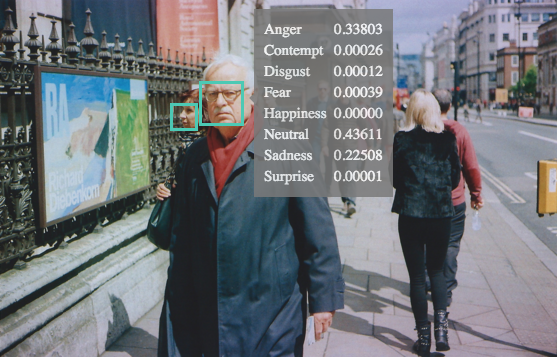
CC https://www.flickr.com/photos/fotologic/23768573841

## Procedimiento para obtener la base de datos

***Declaración de disponibilidad de datos***
por cuestiones de tiempo es necesario la copia de los archivos de entrenamiento [Google drive](https://drive.google.com/drive/folders/1HTTbKvBAwYolZJG_Fhsxw7H4L6KK50LP?usp=sharing ) manualmente a su google drive , si no tiene acceso a la misma también puede reconstruirla con este [link](https://figshare.com/s/64ef1b2fa8838c05c31b), en este caso juntamos solo las carpetas relacionadas al dispositivo 2 o "dev_2" para cada objeto a reconocer.

**Paso 1:**  
Una vez abierto el link se debe encontrar con la siguiente carpeta

 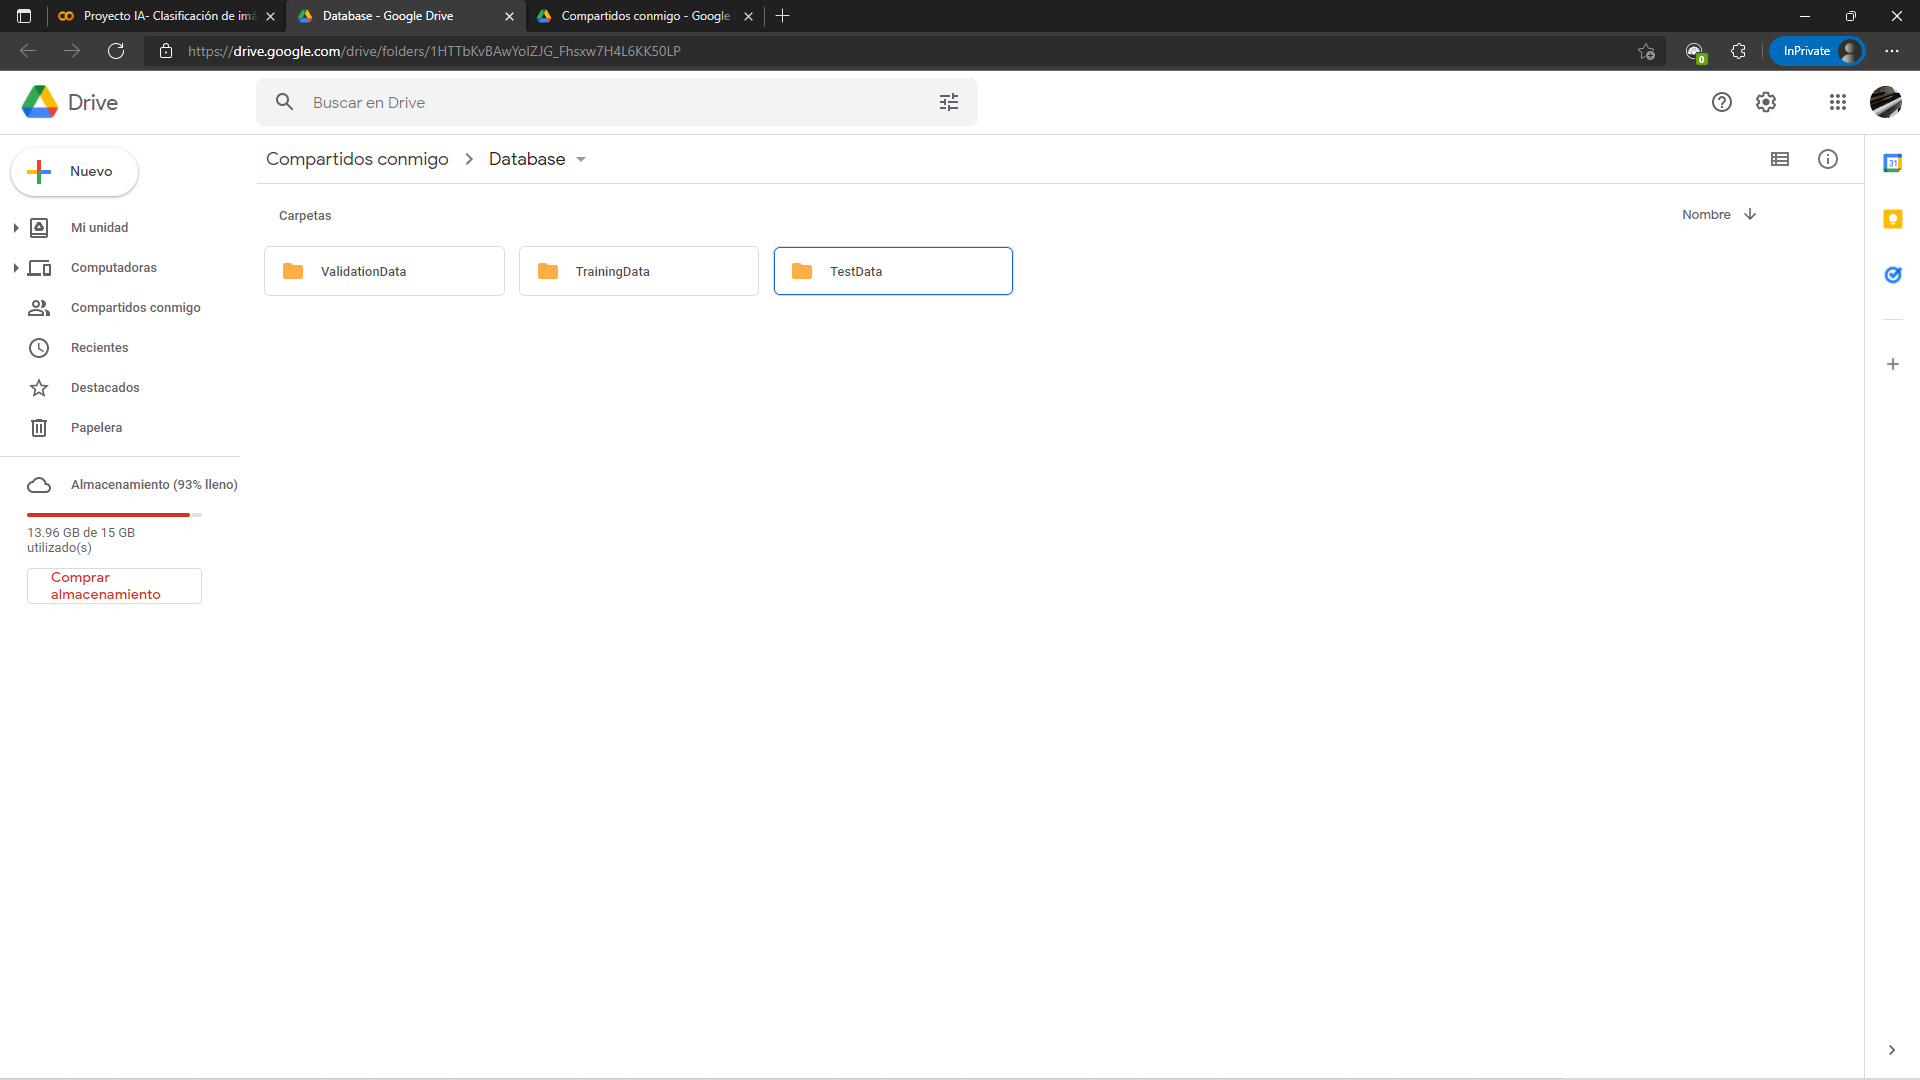



**Paso 2:**  Vamos a seleccionar todas las carpetas y dar click en el botón de tres puntos de "más opciones"
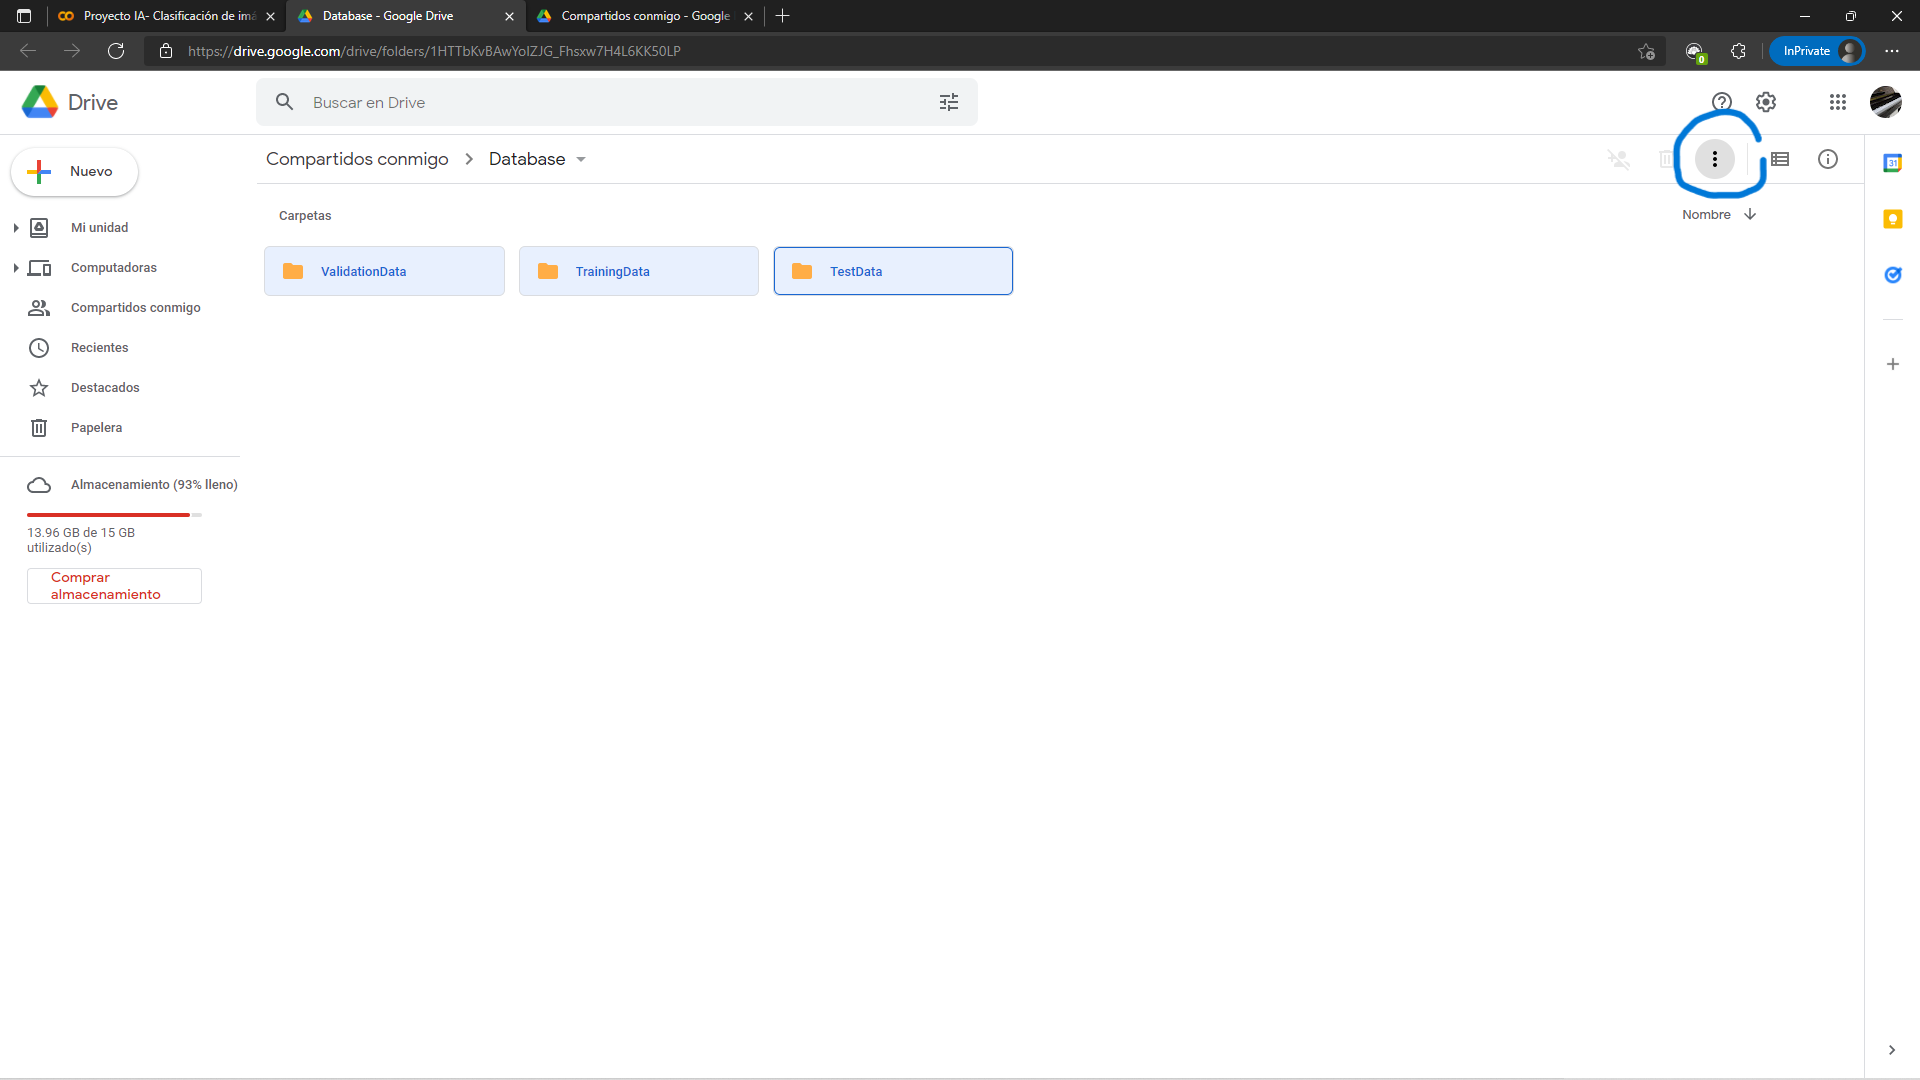


**Paso 3:**  
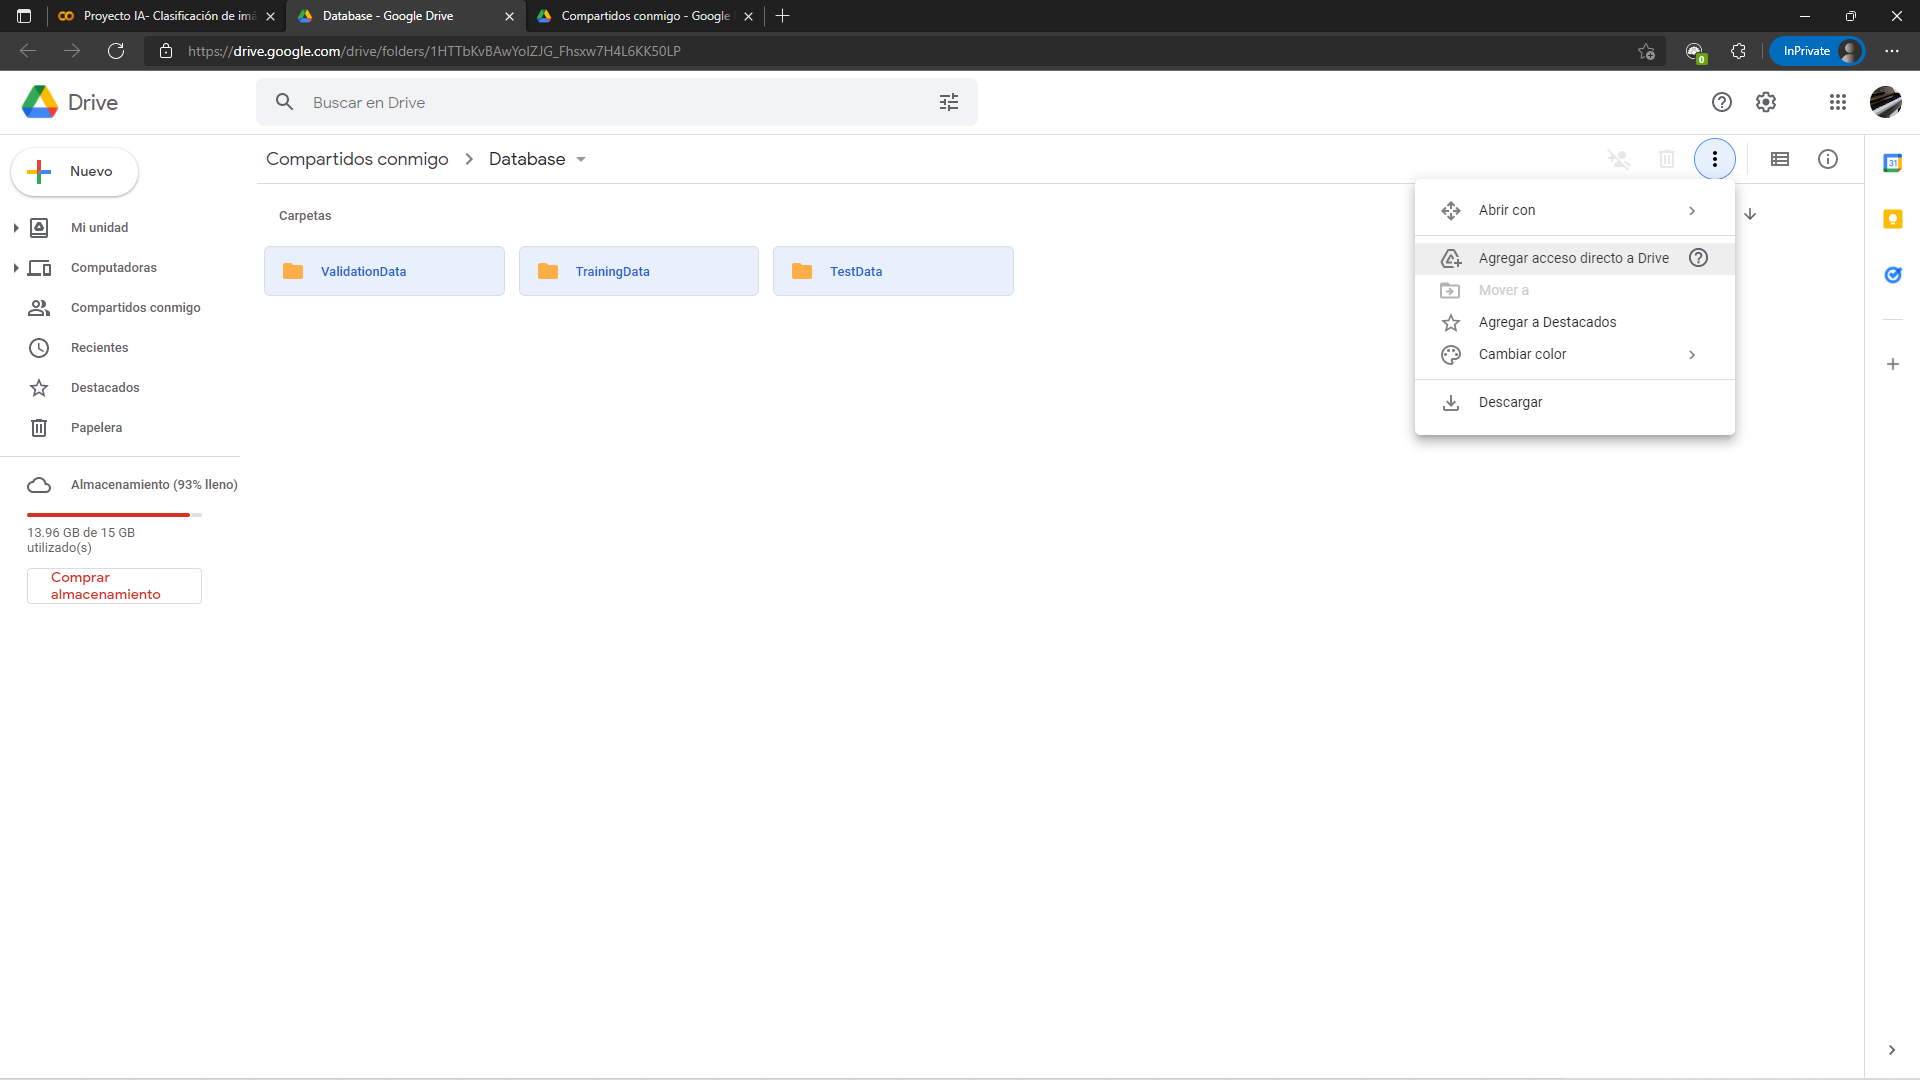

**Paso 4:**  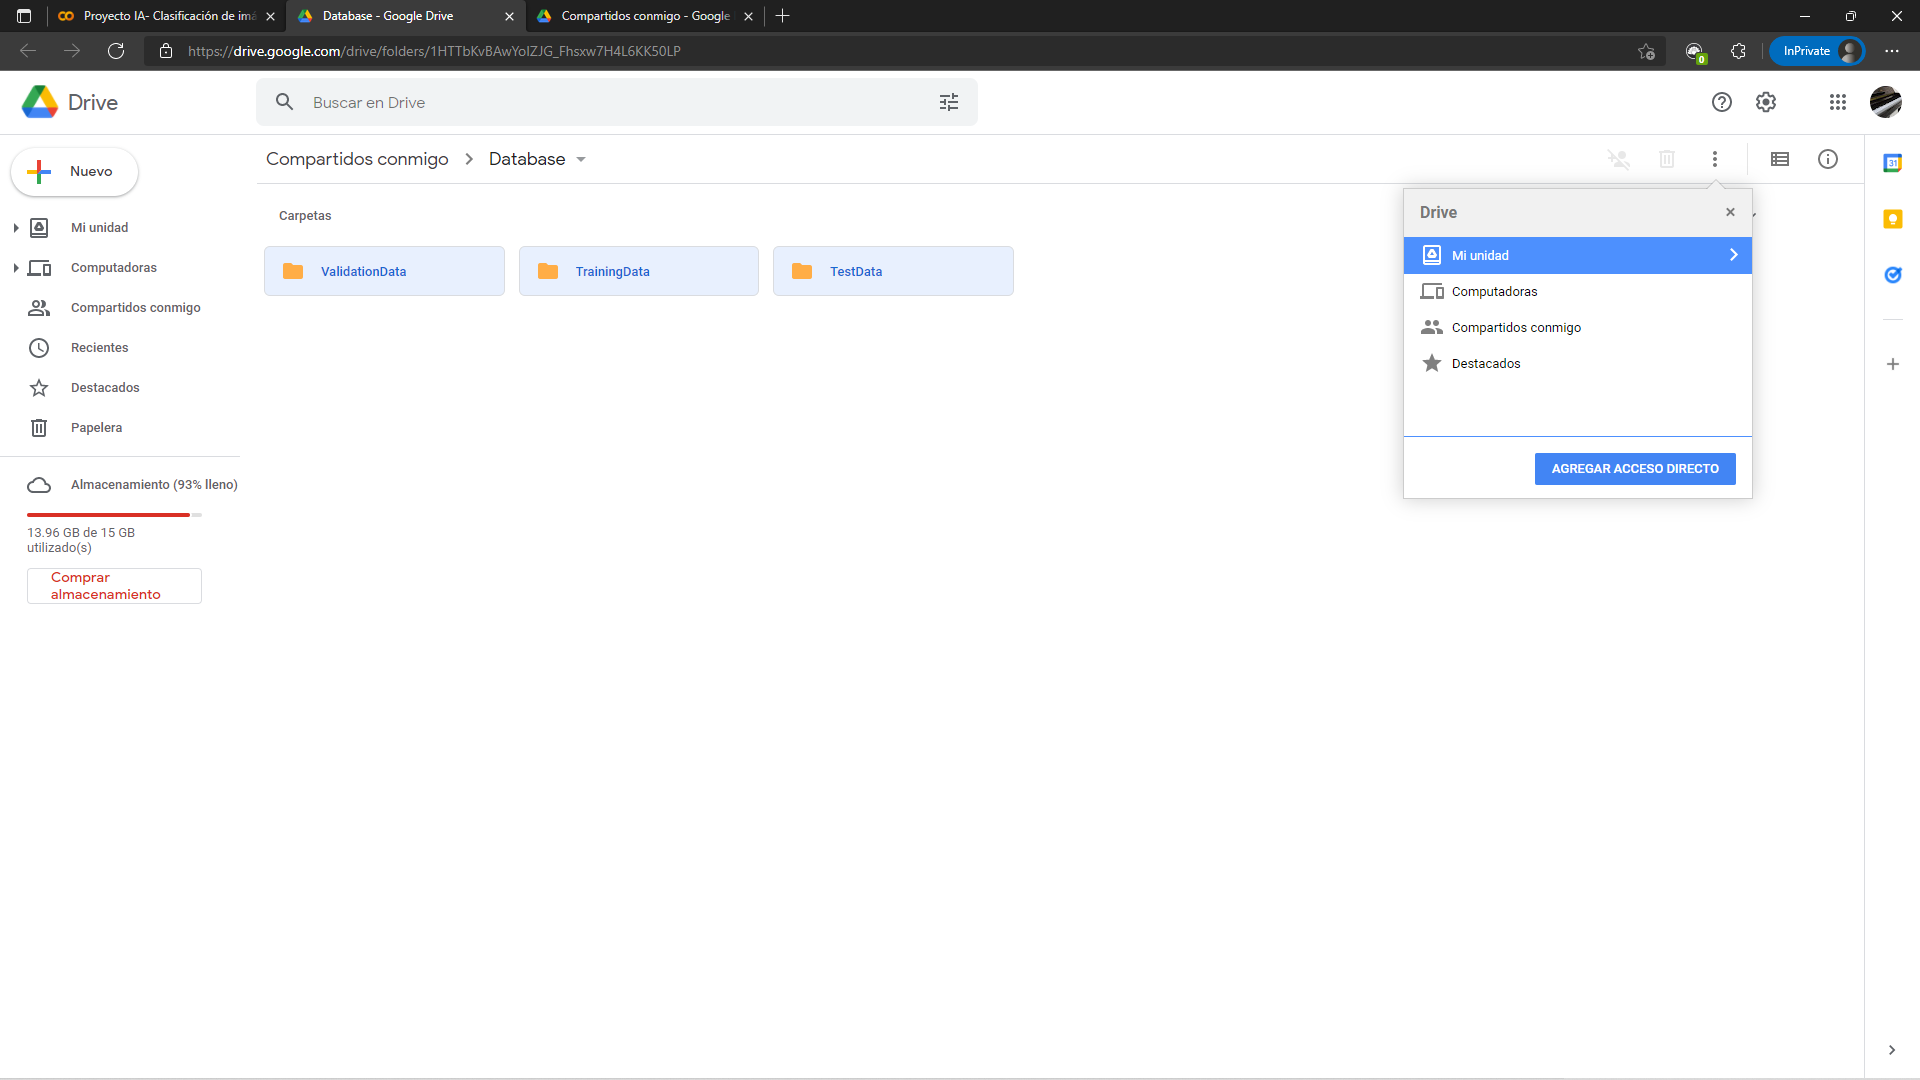


**Paso 5:**  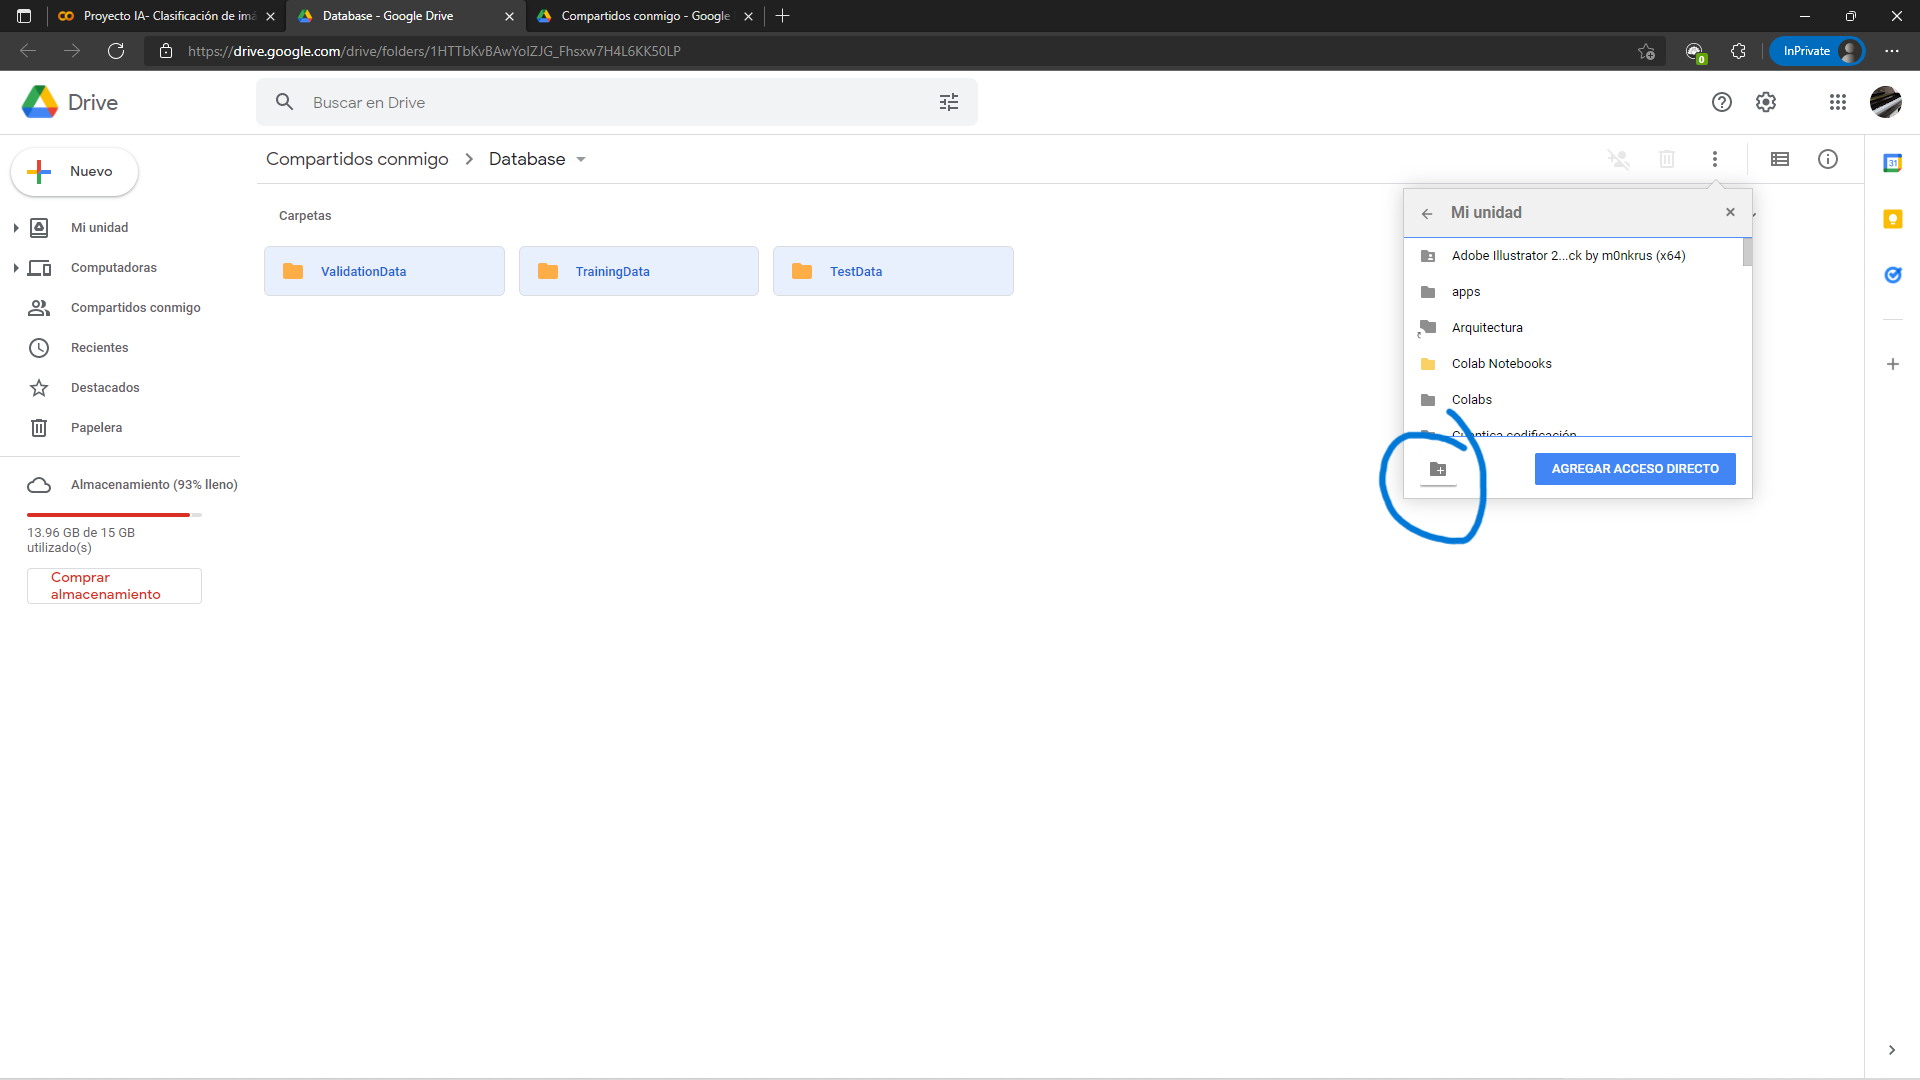


**Paso 6:**  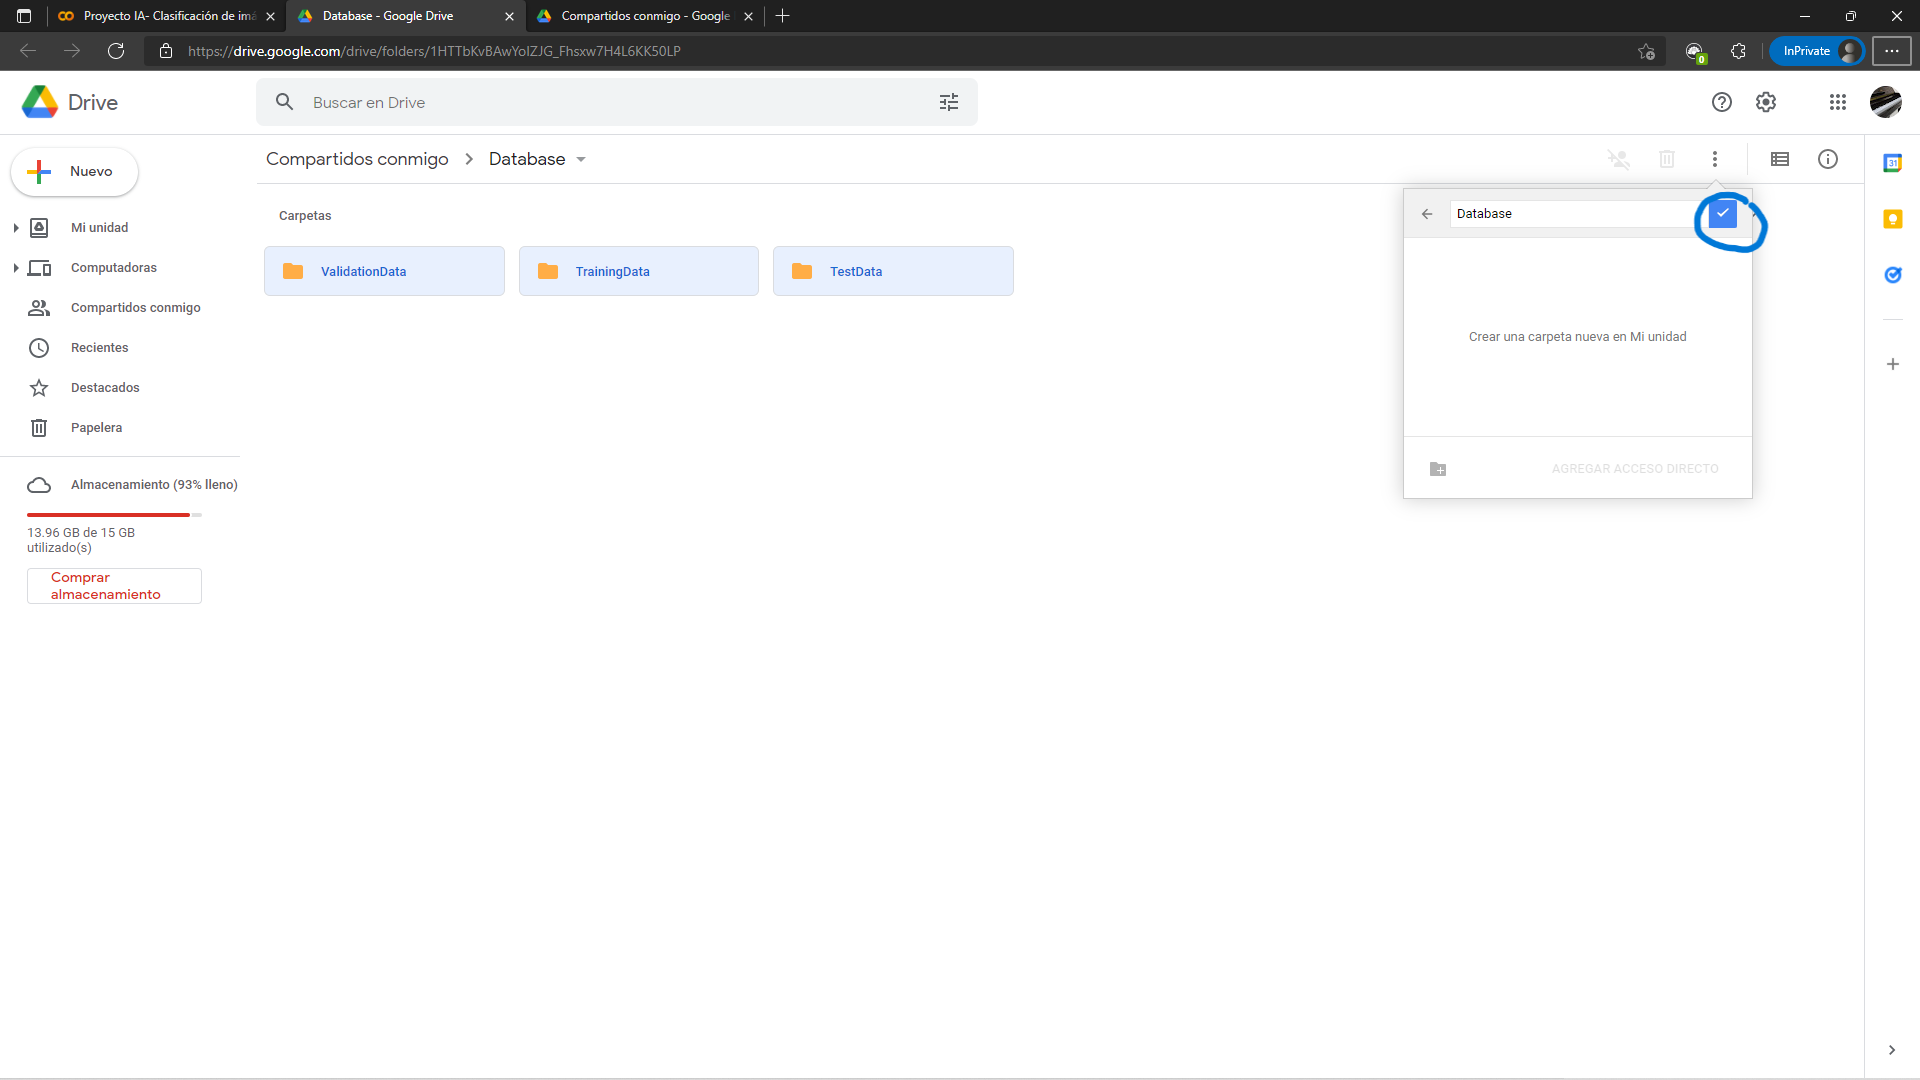


**Paso 7:**  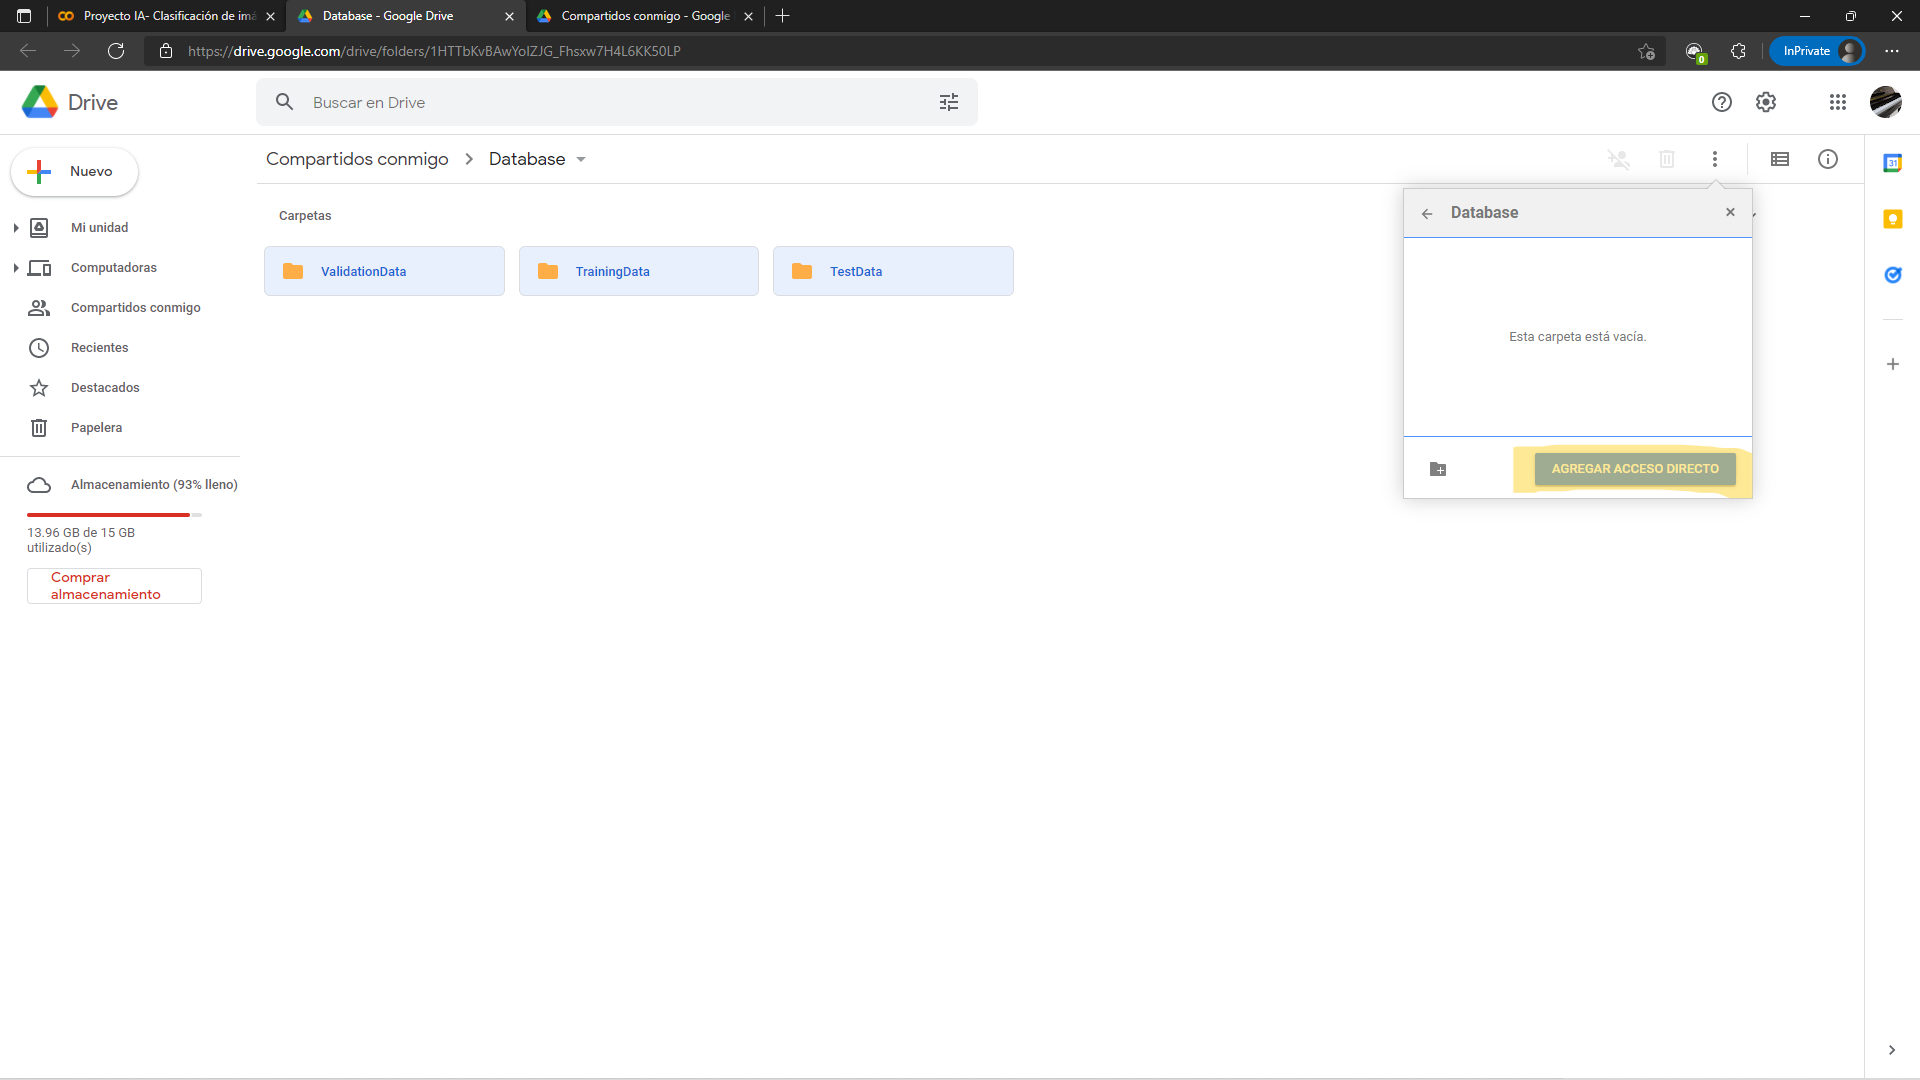


**Paso 8:**  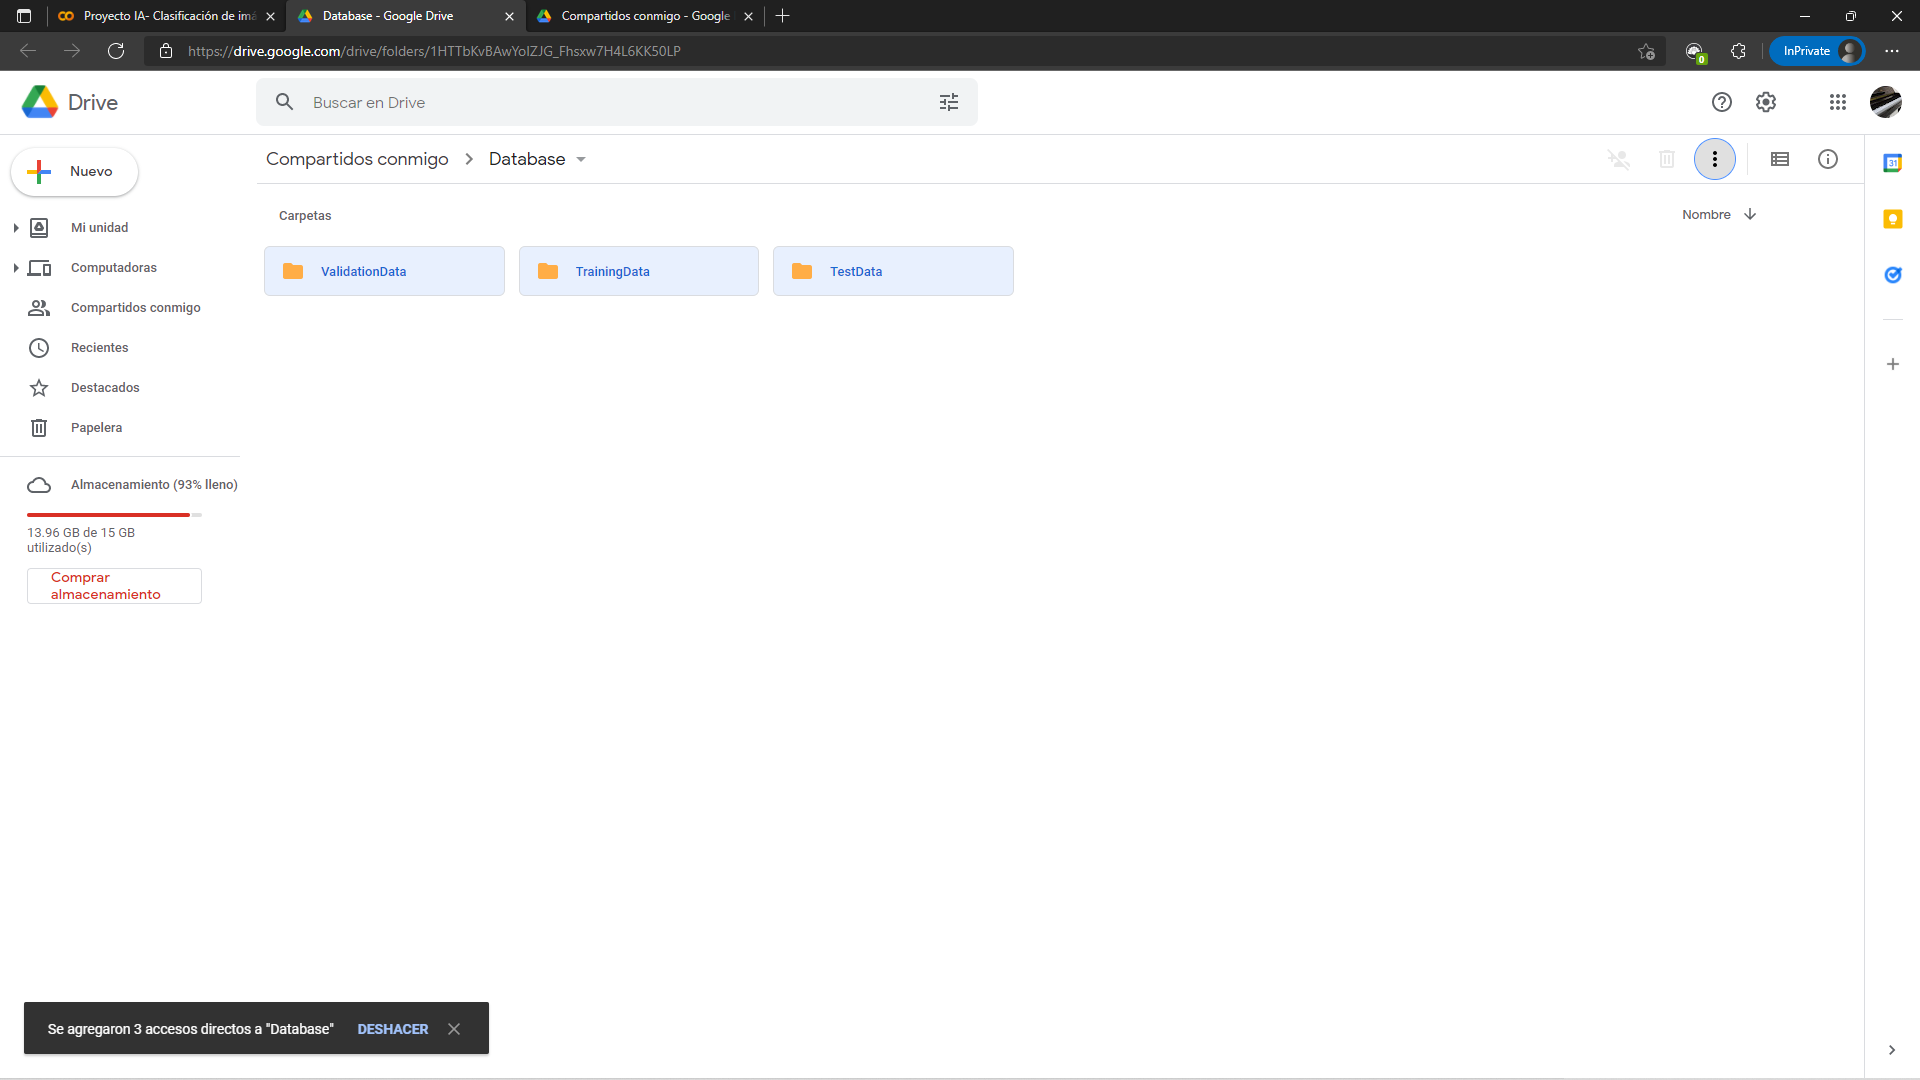

#Importado de datos al notebook

## Librerias 
---

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import glob
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Carga de datos de entrenamiento y validación

In [ ]:
def TD_image_list(figure):
  list_im=[] 
  name= ""
  for device in ["dev1","dev2","dev3","dev4"]:
    name = f"{figure}_{device}_train"
    for filename in glob.glob('/content/gdrive/MyDrive/Database/TrainingData/'+name+'/*.png'): 
    #esta linea debe ser remplazada con la ubicación 
      im=cv2.imread(filename,0)
      list_im.append(im)
  return list_im

def VD_image_list(figure):
  list_im=[] 
  name= ""
  for device in ["dev1","dev2","dev3","dev4"]:
    name = f"{figure}_{device}_validation"
    for filename in glob.glob('/content/gdrive/MyDrive/Database/ValidationData/'+name+'/*.png'): 
    #esta linea debe ser remplazada con la ubicación 
      im=cv2.imread(filename,0)
      list_im.append(im)
  return list_im


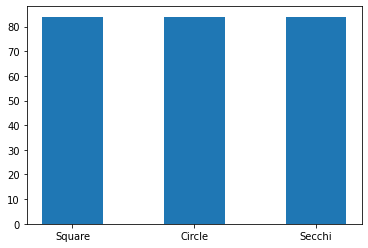

In [ ]:
# Training Data
Square_TD = TD_image_list("Square")
Circle_TD = TD_image_list("SecchiDisk")
Secchi_TD = TD_image_list("Secchi3000")
#Observamos la cantidad de imagenes cargadas
plt.bar(["Square","Circle","Secchi"], [len(Square_TD),len(Circle_TD),len(Secchi_TD)], width=0.5)
plt.show()

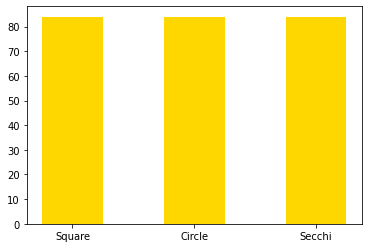

In [ ]:
# Validación Data
Square_VD = VD_image_list("Square")
Circle_VD = VD_image_list("SecchiDisk")
Secchi_VD = VD_image_list("Secchi3000")
#Observamos la cantidad de imagenes cargadas
plt.bar(["Square","Circle","Secchi"], [len(Square_VD),len(Circle_VD),len(Secchi_VD)], width=0.5, color="gold")
plt.show()

Por ahora dejamos la base de datos de testeo vacia, pues no se usara sino hasta el final del documento

# Implementación ***Histogram of Gradients***
---

Las imagenes a las que estamos acostumbrados en este momento rondan los 520x520, 1280x720 o hasta 1920x1080 pixeles. Teniendo en cuenta que cada pixel consta de tres canales, con valores que van del 0 al 256 (8 bits) para las imagenes más livianas tenemos pesos de alrededor de 6 millones de bits

In [ ]:
520*520*8*3

6489600

Teniendo esto en mente, el vector de caracteristicas se va a obtener siguiendo el siguiente proceso



1. Reducir la dimensionalidad de la imagen realizando un reescalamiento del 5%. 
2. Calcular los gradientes horizontales y verticales de la nueva imagen.
3. Calcular la matriz de las orientaciones de los pixeles de la imagen.
4. Realizar una partición de $[-\pi,\pi]$.
5. Construir un vector que describa la distribución de los datos en estos intervalos

El vector del paso 5. resulta siendo nuestro vector de caracteristicas.


In [ ]:
scale=5
num_angle=16

# Resize the image to obtain less dimension of the image
def resize_im(image,scale_percent):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  return cv2.resize(image,(width,height))

# Compute the orientation matrix
def Orientation(matrix,matriy):
  return np.arctan2(matriy,matrix)

# Compute the histogram of the orientation matrix
def Or_histogram(matrix):
  angles=np.linspace(-np.pi,np.pi,num_angle+1)
  hist=np.zeros(num_angle)
  for i in range(num_angle):    
    hist[i]=len(matrix[matrix<angles[i+1]])-len(matrix[matrix<angles[i]])
  hist[-1]+=len(matrix[matrix==np.pi])
  return hist

# Implement the numeric feature
def image_feature(im):
  image=resize_im(im,scale)

  edges_prewitt_h = prewitt_h(image)
  edges_prewitt_v = prewitt_v(image)
  
  orientation_matrix= Orientation(edges_prewitt_h,edges_prewitt_v)
  hist=Or_histogram(orientation_matrix)
  
  hist=hist/(len(image)*len(image[0]))

  return hist

En las siguientes celdas vamos a observar un ejemplo del proceso para encontrar la función caracteristica de cada una de las figuras.

In [ ]:
# Function which plot the original and reduced image, and its respective gradients. 

def plot_gradients(image):
  r_image=resize_im(image,scale)
  edges_prewitt_horizontal = prewitt_h(r_image)
  edges_prewitt_vertical = prewitt_v(r_image)
  orientation_matrix= Orientation(edges_prewitt_horizontal ,edges_prewitt_vertical )
  histog=Or_histogram(orientation_matrix)/(len(r_image)*len(r_image[0]))

  fig, ax = plt.subplots(3, 2, figsize=(12,12)) 
  ax[0,0].imshow(image)
  ax[0,0].set_title('Imagen Original',fontsize=12)
  ax[0,1].imshow(r_image)
  ax[0,1].set_title('Reducción de la imagen al 5%',fontsize=12)
  ax[1,0].imshow(edges_prewitt_horizontal, cmap='gray')
  ax[1,0].set_title('Gradiente Horizontal',fontsize=12)
  ax[1,1].imshow(edges_prewitt_vertical, cmap='gray')
  ax[1,1].set_title('Gradiente Vertical',fontsize=12)
  ax[2,0].imshow(orientation_matrix, cmap='gray')
  ax[2,0].set_title('Matriz de la orientación',fontsize=12)
  ax[2,1].bar(range(1,17), histog)
  ax[2,1].yaxis.grid()
  ax[2,1].set_title('Histograma de las orientaciones',fontsize=12)

  fig.show()

Proceso para calcular la función característica para un cuadrado

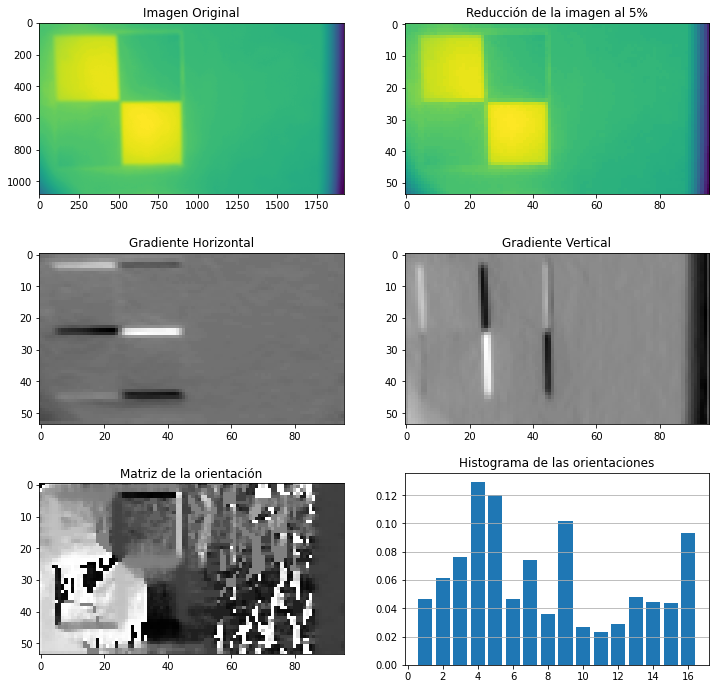

In [ ]:
plot_gradients(Square_TD[np.random.randint(50)])

Proceso para calcular el vector característica para un círculo

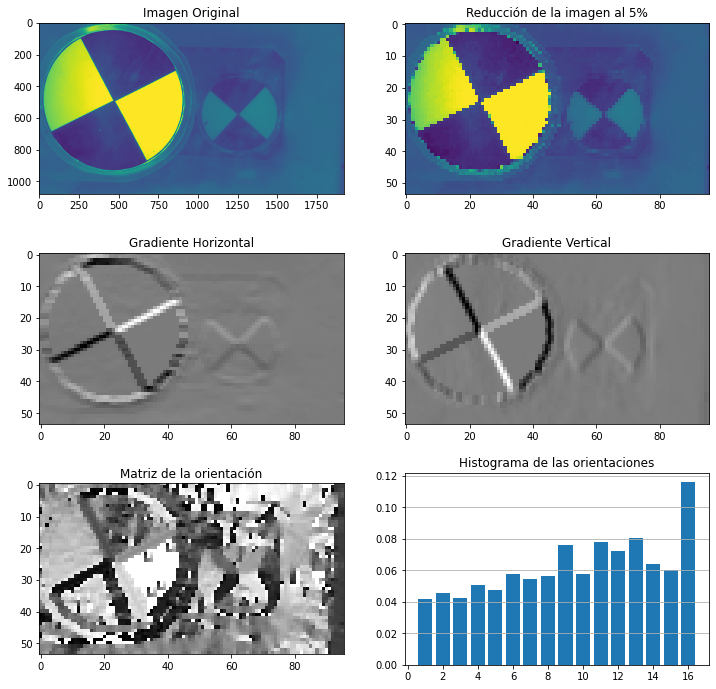

In [ ]:
plot_gradients(Circle_TD[np.random.randint(50)])

Proceso para calcular la función característica para un Secchi3000

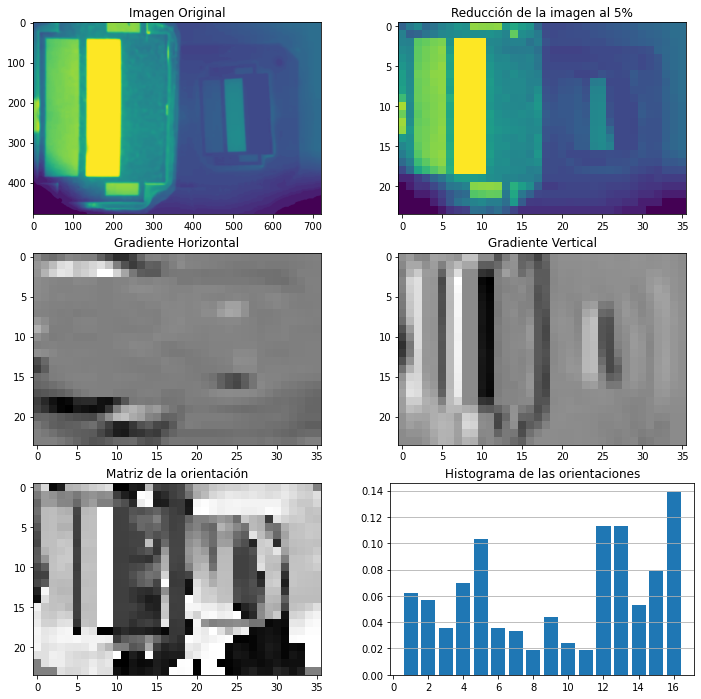

In [ ]:
plot_gradients(Secchi_TD[np.random.randint(50)])

Acá aplicamos entonces el filtro a los datos 

In [ ]:
#Characterization of the training images 

XTD=[]
YTD=[]
# Set 1 for representing squares, 2 for circles, 3 for secchi
for im in Square_TD:
  XTD.append(image_feature(im))
  YTD.append(1)

for im in Circle_TD:
  XTD.append(image_feature(im))
  YTD.append(2)

for im in Secchi_TD:
  XTD.append(image_feature(im))
  YTD.append(3)

XTD=np.array(XTD)

In [ ]:
#Characterization of the validation images 

XVD=[]
YVD=[]
# Set 1 for representing squares, 2 for circles, 3 for secchi
for im in Square_VD:
  XVD.append(image_feature(im))
  YVD.append(1)

for im in Circle_VD:
  XVD.append(image_feature(im))
  YVD.append(2)

for im in Secchi_VD:
  XVD.append(image_feature(im))
  YVD.append(3)


XVD=np.array(XVD)

##Preprocesamiento datos 



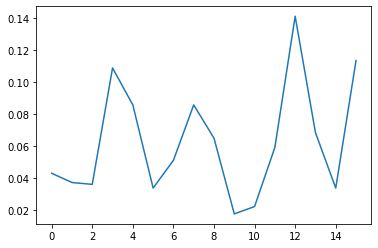

In [ ]:
plt.plot(XVD[0])

In [ ]:
# from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = XTD,XVD,YTD,YVD


#we show we indeed have a random sample
print(X_train)


[[0.03587963 0.02199074 0.03009259 ... 0.06828704 0.04861111 0.09606481]
 [0.03935185 0.04282407 0.02893519 ... 0.07060185 0.04166667 0.09953704]
 [0.04166667 0.04050926 0.06018519 ... 0.06134259 0.04282407 0.10300926]
 ...
 [0.02334105 0.02507716 0.04263117 ... 0.04301698 0.03530093 0.04205247]
 [0.02700617 0.02642747 0.03395062 ... 0.07928241 0.04243827 0.04552469]
 [0.02025463 0.04128086 0.02488426 ... 0.04108796 0.04552469 0.07986111]]


In [ ]:
print(X_val)

[[0.04282407 0.03703704 0.03587963 ... 0.06828704 0.03356481 0.11342593]
 [0.0474537  0.03009259 0.03009259 ... 0.07986111 0.03935185 0.09953704]
 [0.0474537  0.04166667 0.06018519 ... 0.0775463  0.04282407 0.09953704]
 ...
 [0.03819444 0.03607253 0.04552469 ... 0.04918981 0.04263117 0.06867284]
 [0.03954475 0.03260031 0.03665123 ... 0.04224537 0.03472222 0.06481481]
 [0.04282407 0.03607253 0.03491512 ... 0.04494599 0.03761574 0.08314043]]


Acá entrenamos diferente modelos logisticos con diferentes parametros C, en primera instancia cuando usabamos un HOG discretizado a solo 8 intervalos C=1 daba resultados muy malos debajo del 10% no solo en entrenamiento sino en validación, con la ultima adaptación con 16 intervalos, la precisión ahora es casi un orden de magnitud mayor, y de hecho en los otros modelos logra una validación muy alta

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1)
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.5f}'
    .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on validation set: {:.5f}'
    .format(logreg.score(X_val, y_val)))

Accuracy of Logistic regression classifier on training set: 0.82540
Accuracy of Logistic regression classifier on validation set: 0.82540


In [ ]:
#Detect 3/Secchi predictions
np.where(logreg.predict(X_train) == 3)

(array([  6,   8,  16,  17,  23,  24,  25,  26,  27,  51, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 195, 199, 202, 203, 204, 205, 206, 207,
        208, 209, 218, 221, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251]),)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10)
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.5f}'
    .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on validation set: {:.5f}'
    .format(logreg.score(X_val, y_val)))

Accuracy of Logistic regression classifier on training set: 0.85317
Accuracy of Logistic regression classifier on validation set: 0.86508


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=60)
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.5f}'
    .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on validation set: {:.5f}'
    .format(logreg.score(X_val, y_val)))

Accuracy of Logistic regression classifier on training set: 0.90873
Accuracy of Logistic regression classifier on validation set: 0.92063


Acá tenemos nuestro primer modelo, (recordemos logreg tiene el ultimo modelo que ejecutamos) podemos ver a quien esta clasificando como Rectangulo (Secchi) los valores de entrenamiento

In [ ]:
#Detect 3/Secchi predictions
an_array = np.where(logreg.predict(X_train) == 3)
an_array[0]

array([  8,  17,  50,  51,  63,  75,  83, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 190, 193, 195, 198, 199, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 217, 218, 219, 221, 222, 224, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251])

In [ ]:
#Real 3/Secchi predictions
another_array = np.where(np.array(y_train)==3)
another_array[0]

array([168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251])

En efecto reconoce todos los Rectangulos de validación

#Otros modelos

**K nearest neighbor**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
print('Accuracy of K-NN-1 classifier on training set: {:.2f}'
     .format(knn1.score(X_train, y_train)))
print('Accuracy of K-NN-1 classifier on validation set: {:.2f}'
     .format(knn1.score(X_val, y_val)))

knn2 = KNeighborsClassifier(n_neighbors=2)
knn2.fit(X_train, y_train)
print('Accuracy of K-NN-2 classifier on training set: {:.2f}'
     .format(knn2.score(X_train, y_train)))
print('Accuracy of K-NN-2 classifier on validation set: {:.2f}'
     .format(knn2.score(X_val, y_val)))

knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, y_train)
print('Accuracy of K-NN-2 classifier on training set: {:.2f}'
     .format(knn3.score(X_train, y_train)))
print('Accuracy of K-NN-2 classifier on validation set: {:.2f}'
     .format(knn3.score(X_val, y_val)))


Accuracy of K-NN-1 classifier on training set: 1.00
Accuracy of K-NN-1 classifier on validation set: 1.00
Accuracy of K-NN-2 classifier on training set: 0.98
Accuracy of K-NN-2 classifier on validation set: 0.98
Accuracy of K-NN-2 classifier on training set: 0.98
Accuracy of K-NN-2 classifier on validation set: 0.99


**Linear Discriminant**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on validation set: {:.2f}'
     .format(lda.score(X_val, y_val)))

Accuracy of LDA classifier on training set: 0.95
Accuracy of LDA classifier on validation set: 0.95


**Suport Vector Machines**

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on validation set: {:.2f}'
     .format(svm.score(X_val, y_val)))

Accuracy of SVM classifier on training set: 0.96
Accuracy of SVM classifier on validation set: 0.96


**Naive_Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on validation set: {:.2f}'
     .format(gnb.score(X_val, y_val)))

Accuracy of GNB classifier on training set: 0.81
Accuracy of GNB classifier on validation set: 0.81


#Código estilizado de matriz de confusión

**Matrices de confusión**
Finalmente vamos a generar las matrices de confusión de todos los modelos antes de decir cual poner a prueba

In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Predicted label')
        plt.xlabel('True label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
    plt.show()

#Validación

LogisticRegression



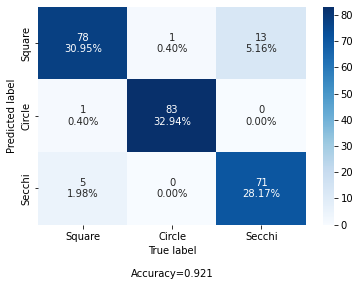

In [ ]:
categories = ['Square', 'Circle','Secchi']


print(type(logreg).__name__,end="\n\n")
cf_matrix=confusion_matrix(logreg.predict(X_val),y_val)
make_confusion_matrix(cf_matrix, 
                    #group_names=labels,
                    categories=categories, 
                    cmap='Blues')



KNeighborsClassifier



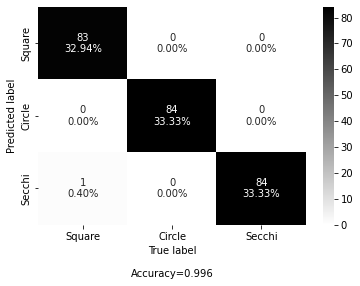

In [ ]:
categories = ['Square', 'Circle','Secchi']

  
print(type(knn1).__name__,end="\n\n")
cf_matrix=confusion_matrix(knn1.predict(X_val),y_val)
make_confusion_matrix(cf_matrix, 
                    #group_names=labels,
                    categories=categories, 
                    cmap='binary')


LinearDiscriminantAnalysis



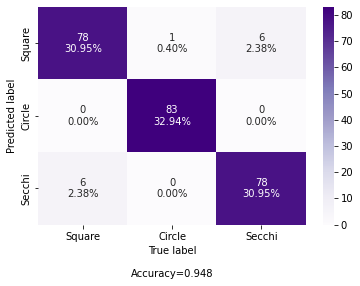

In [ ]:
categories = ['Square', 'Circle','Secchi']

  
print(type(lda).__name__,end="\n\n")
cf_matrix=confusion_matrix(lda.predict(X_val),y_val)
make_confusion_matrix(cf_matrix, 
                    #group_names=labels,
                    categories=categories, 
                    cmap="Purples")


SVC



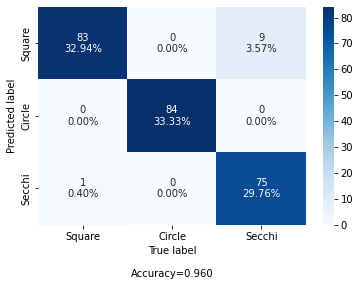

In [ ]:
categories = ['Square', 'Circle','Secchi']

  
print(type(svm).__name__,end="\n\n")
cf_matrix=confusion_matrix(svm.predict(X_val),y_val)
make_confusion_matrix(cf_matrix, 
                    #group_names=labels,
                    categories=categories, 
                    cmap='Blues')


GaussianNB



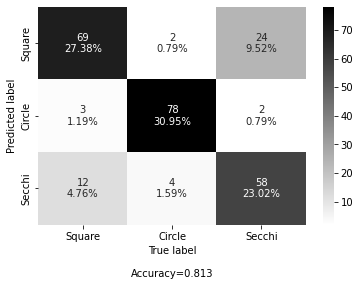

In [ ]:
categories = ['Square', 'Circle','Secchi']

  
print(type(gnb).__name__,end="\n\n")
cf_matrix=confusion_matrix(gnb.predict(X_val),y_val)
make_confusion_matrix(cf_matrix, 
                    #group_names=labels,
                    categories=categories, 
                    cmap='binary')


Elegimos K Neighboors porque fue el más superior por lejos de los demas, incluso con valores diversos de K

## Resultados

In [ ]:
def Test_image_list(figure):
  list_im=[] 
  name= ""
  for device in ["dev1","dev2","dev3","dev4"]:
    name = f"{figure}_{device}_test"
    for filename in glob.glob('/content/gdrive/MyDrive/Database/TestData/'+name+'/*.png'): 
    #esta linea debe ser remplazada con la ubicación 
      im=cv2.imread(filename,0)
      list_im.append(im)
  return list_im


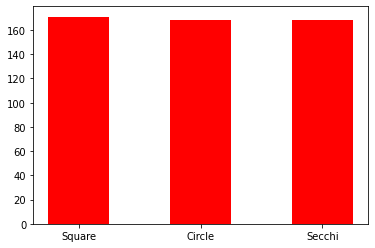

In [ ]:
# Test Data
Square_test = Test_image_list("Square")
Circle_test = Test_image_list("SecchiDisk")
Secchi_test = Test_image_list("Secchi3000")
#Observamos la cantidad de imagenes cargadas
plt.bar(["Square","Circle","Secchi"], [len(Square_test),len(Circle_test),len(Secchi_test)], width=0.5, color="red")
plt.show()

In [ ]:
#Characterization of the testing images 

TX=[]
TY=[]
# Set 1 for representing squares, 2 for circles, 3 for secchi
for im in Square_test:
  TX.append(image_feature(im))
  TY.append(1)

for im in Circle_test:
  TX.append(image_feature(im))
  TY.append(2)

for im in Secchi_test:
  TX.append(image_feature(im))
  TY.append(3)


TX=np.array(TX)

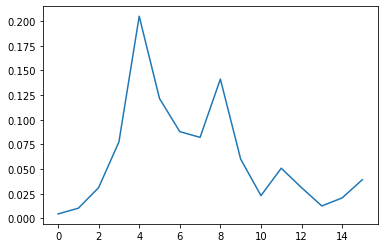

In [ ]:
plt.plot(TX[0])

KNeighborsClassifier



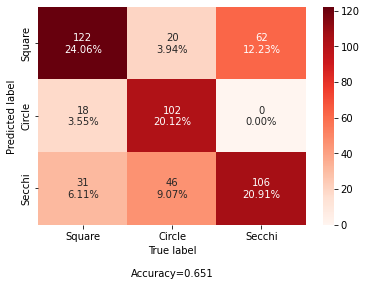

In [ ]:
categories = ['Square', 'Circle','Secchi']

  
print(type(knn1).__name__,end="\n\n")
cf_matrix=confusion_matrix(knn1.predict(TX),TY)
make_confusion_matrix(cf_matrix, 
                    #group_names=labels,
                    categories=categories, 
                    cmap='Reds')

Se observa que Knn-1 tuvo una eficacia del 67%. Notemos en particular que el agente falló considerablemente seguido en la diferenciación entre Secchi y cuadrado, lo que es relativamente razonable. A pesar de que el modelo tuvo buenos resultados en entrenamiento y validación, no mostró el mismo rendimiento con los datos de testeo; por eso mismo creemos Sería importante un conocimiento más amplio respecto a los modelos para evitar mejor la memorización no solo guiandonos por una validación alta.

## Referencias
---

[1] Singh, A., 2019. Feature Descriptor | Hog Descriptor Tutorial. [online] Analytics Vidhya. Available at: <https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/> [Accessed 9 February 2022].

[2] Trimarchi, D., 2019. confusion_matrix/cf_matrix.py at master · DTrimarchi10/confusion_matrix. [online] GitHub. Available at: <https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py> [Accessed 9 February 
2022].

[3]  Villamil, J.,  Victorino, J., Gómez, F.; The effect of mobile camera selection on the capacity to predict water turbidity. Water Sci Technol 15 November 2021; 84 (10-11): 2749–2759. doi: <https://doi.org/10.2166/wst.2021.238>

[4] Cheng, M.,Kovalevskyi, V.; Jupyter Notebook Manifesto: Best practices that can improve the life of any developer using Jupyter notebooks at
  <https://cloud.google.com/blog/products/ai-machine-learning/best-practices-that-can-improve-the-life-of-any-developer-using-jupyter-notebooks> [Accessed 10 February 2022]
  